In [2]:
# importation des modules nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image
from scipy import stats

## Récupérer les fichiers CSV:

In [4]:
# on récupère les informations du dossier
dossier = './raw_data'
contenuDossier = os.listdir(dossier)
print(contenuDossier)
nombrePoints = 0
nomPoints = []
numeroPoints = []
# on parcours le dossier en recherchant les fichiers des points
# on récupère leur nom, leur numéro et leur nombre
for x in contenuDossier:
    if x.startswith('point') :
        nombrePoints += 1
        nomPoints.append(x)
        numeroPoints.append(x[5:7])
print(nomPoints)
print(numeroPoints)

['point35', 'point14_29_07_15', 'point15_29_07_15', 'schema_dispositif_AvAv_23_07_15.png', 'point47_27_08_19', 'point13_29_07_15', 'point36_12_07_16', 'point46_17_06_19', 'point34_27_06_16', 'point48_14_04_18', 'point50_13_10_23', 'point51_13_10_23']
['point35', 'point14_29_07_15', 'point15_29_07_15', 'point47_27_08_19', 'point13_29_07_15', 'point36_12_07_16', 'point46_17_06_19', 'point34_27_06_16', 'point48_14_04_18', 'point50_13_10_23', 'point51_13_10_23']
['35', '14', '47', '13', '36', '46', '34', '48', '50', '51']


In [6]:
def read_csv (chemin_fichier):
    ''' Fonction qui permet de lire un fichier csv et de le convertir en dataframe pandas'''
    # on commence par détecter quel séparateur est utilisé dans le csv
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)
    # on regarde si il y a un titre dans le csv, si c'est le cas, il faut lire le csv à partir de la 1e ligne
    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)
        
    return data_frame 

In [7]:
# on va regrouper toutes les informations liées à un point dans un dictionnaire et puis faire une liste
# qui regroupe tous les dictionnaires
data = []
for x in nomPoints :
    # récupération des informations du point
    dico = {}
    # le numéro
    dico['numero'] = x[5:7]
    # le nom
    dico['nom'] = x
    # la date
    dico['date'] = x[8:18]
    # le chemin vers le dossier
    dico['chemin'] = dossier + '/' + x
    with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
        lignes = fichier.readlines()
        # le nom du capteur
        dico['capteur'] = lignes[1][:-1]
        # la profondeur du capteur
        if lignes[3] == '\n' :
            dico['profondeur'] = 0
        else : 
            dico['profondeur'] = lignes[3]
        # les profondeurs auquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))

    # on met ensuite les deux dataframes pression et température dans le dictionnaire
    contenuDossierPoint = os.listdir(dico['chemin'])
    for x in contenuDossierPoint:
        # la pression
        if (x.startswith('p') and x.endswith('.csv')) and not x.endswith('cleaned.csv') :
            dico['pression'] = read_csv(dico['chemin'] + '/' + x)
        # la température
        if x.startswith('t') and x.endswith('.csv'):
            dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
    # dans les configurations du capteur on va intercept, dU/dH et dU/dT qui vont servir au calcul de dH
    chemin_etalonnage = 'configuration/pressure_sensors/P' + dico['capteur'][1:] +'.csv'
    if os.path.exists(chemin_etalonnage):
        with open(chemin_etalonnage) as fichier :
            lignes = fichier.readlines()
            for l in lignes :
                if l.startswith('Intercept') :
                    dico['intercept'] = float(l[10:-2])
                if l.startswith('dU/dH') :
                    dico['dU/dH'] = float(l[6:-2])
                if l.startswith('dU/dT') :
                    dico['dU/dT'] = float(l[6:-2])
    data.append(dico)


# Est ce que les fichiers peuvent être utilisés ?

**Dans notre cas, nous prendrons ces solutions**

* S'il manque toutes les données du capteurs de pression ou l'étalonnage, nous déciderons que ce point est invalide.
* S'il manque une partie des données nous vérifierons que nous avons au mimimun 7 jours de données
* S'il manque plus de 2 capteurs de température, nous déciderons que ce point est invalide.

### Est ce que nous avons les données de l'étalonnage du capteur ?

In [8]:
for x in data :
    if not 'intercept' in x.keys() :
        print('le point '+ x['numero'] + ' n\'a pas d\'étalonnage, il n\'est pas valide')
        data.remove(x)

### Est ce que nous avons des données pour le capteur de pression ?

In [9]:
for x in data :
    if x['pression'].empty :
        print('le point '+ x['numero'] + ' n\'a pas de données de pression, il n\'est pas valide')
        data.remove(x)

### On modifie les nom des colonnes du dataframe
Pour les rendre plus propres et les homogénéiser. 

In [238]:
for x in data :
    # on supprime les colonnes qui ne servent à rien
    for i in x['temperature'].columns :
        if not( i.startswith(('Date', 'date', 'temp','Temp'))) :
            del x['temperature'][i]
    for i in x['pression'].columns :
        if not( i.startswith(('Date', 'date', 'Tension', 'tension', 'Pressure', 'pressure', 'temp', 'Temp'))) :
            del x['pression'][i]
    # on renomme les colonnes
    profondeur = x['profondeurMesures']
    # les colonnes de la température
    colonnesT = ['dates']
    for num in profondeur :
        colonnesT.append('Temp_profondeur_'+ str(num))
    x['temperature'].columns = colonnesT
    # les colonnes de la pression
    colonnesP = ['dates', 'tension', 'temperature_stream']
    x['pression'].columns = colonnesP    

## Conversion des valeurs de tension en differance de charge

In [239]:
for point in data:
    k0 = float(point['intercept'])
    k1 = float(point['dU/dH'])
    k2 = float(point['dU/dT'])
    
    # Calcul de la colonne 'dH' en utilisant la formule H = 1/k1 * (U - k0 - k2 * T)
    U = point['pression']['tension'].astype(float)
    T = point['pression']['temperature_stream'].astype(float)
    point['pression']['dH'] = (1 / k1) * (U - k0 - k2 * T)

### On enlève les valeurs Nan

In [240]:
for x in data :
    x['temperature'] = x['temperature'].dropna(axis = 0, how = 'any')
    x['pression'] = x['pression'].dropna(axis = 0, how='any')

In [241]:
from dateutil import parser

# Conversion dans le bon format date
for x in data:
    x['pression']['dates'] = x['pression']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
    x['temperature']['dates'] = x['temperature']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))

In [242]:
for x in data :
    # Traiter chaque colonne sauf la colonne des dates
    columns_to_processP = [col for col in x['pression'].columns if col != 'dates']
    columns_to_processT = [col for col in x['temperature'].columns if col != 'dates']
    # Créer un DataFrame vide pour stocker les données traitées
    x['pression2'] = x['pression'][['dates']].copy()
    x['temperature2'] = x['temperature'][['dates']].copy()
    # Boucler à travers chaque colonne à traiter
    for column_name in columns_to_processP :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['pression'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['pression'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['pression2'][column_name] = df_cleaned[column_name]
    # pareil pour les températures
    for column_name in columns_to_processT :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['temperature'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['temperature'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['temperature2'][column_name] = df_cleaned[column_name]

In [243]:
def nb_val_abberantes(capteur_riviere, capteur_ZH):
    df = capteur_ZH.copy()
    df["temperature_stream"] = capteur_riviere[["temperature_stream"]]
    df["dH"] = capteur_riviere[["dH"]]
    for column in df.columns:
        if column != "dates":
            print(f"Analyse pour la colonne : {column}")
            
    # Créer un DataFrame vide pour stocker les données traitées
    df_processed = df[["dates"]].copy()

    # Boucler à travers chaque colonne de df
    for column_name in df.columns:
        if column_name == "dates":
            continue  # Ignorer la colonne des dates
            
        # Traiter la colonne et stocker les données traitées dans df_processed
        median, q1, q3, iqr, minimum, maximum = calculate_quantiles_iqr(df, column_name)
        df_processed[f"{column_name}"] = remove_outliers(df, column_name)[column_name]
        
    # Afficher les statistiques des données traitées
    print(df_processed.describe())
    return df, df_processed

In [244]:
# Fonction pour calculer les statistiques et les valeurs IQR
def calculate_quantiles_iqr(df, column_name):
    median = df[column_name].median()
    # Calculer les quantiles Q1 et Q3 pour la colonne spécifiée
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    
    # Calculer l'IQR
    iqr = q3 - q1
    minimum = q1 - 1.5 * iqr  # Valeur minimale (|- dans la boîte à moustaches)
    maximum = q3 + 1.5 * iqr  # Valeur maximale (-| dans la boîte à moustaches)
    return median, q1, q3, iqr, minimum, maximum

# Fonction pour obtenir un texte décrivant les statistiques de base
def get_iqr_text(df, col_name):
    # Calcul des statistiques de base
    median, q1, q3, iqr, minimum, maximum = calculate_quantiles_iqr(df, col_name)
    
    # Création du texte
    text = f"médiane={median:.2f}, Q1={q1:.2f}, Q3={q3:.2f}, IQR={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

# Fonction pour supprimer les valeurs aberrantes
def remove_outliers(df, col_name):
    # Obtention des limites pour les valeurs non aberrantes
    _, _, _, _, minimum, maximum = calculate_quantiles_iqr(df, col_name)
    
    # Sélection des lignes avec des valeurs non aberrantes
    df_out = df.loc[(df[col_name] > minimum) & (df[col_name] < maximum)]
    return df_out

# Fonction pour compter les valeurs aberrantes
def count_outliers(df_in, col_name):
    # Obtention des limites pour les valeurs aberrantes
    _, _, _, _, minimum, maximum = calculate_quantiles_iqr(df_in, col_name)
    
    # Sélection des lignes avec des valeurs aberrantes
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    
    # Comptage des valeurs aberrantes
    num_outliers = df_outliers.shape[0]
    return num_outliers

# Fonction pour générer un graphique de boîte à moustaches
def box_and_whisker(df_in, col_name):
    # Obtention du texte décrivant les statistiques
    title = get_iqr_text(df_in, col_name)
    
    # Tracé du graphique de boîte à moustaches
    sns.boxplot(df_in[col_name])
    plt.title(title)
    plt.show()

# Fonction pour tracer les données avec et sans valeurs aberrantes
def plot_data_with_and_without_outliers(df, col_name):
    plt.figure(figsize=(12, 6))
    
    # Tracé des données brutes
    plt.subplot(1, 2, 1)
    plt.title("Données brutes")
    sns.boxplot(df[col_name])
    
    # Tracé des données sans valeurs aberrantes
    plt.subplot(1, 2, 2)
    plt.title("Données sans valeurs aberrantes")
    df_cleaned = remove_outliers(df, col_name)
    sns.boxplot(df_cleaned[col_name])
    
    plt.tight_layout()
    plt.show()


In [245]:
for x in data :
    df_processed  = nb_val_abberantes(x['pression'], x['temperature'])[1]
    df_processed = df_processed.dropna(axis = 0, how='any')
    x['pression2'] = df_processed[['dates', 'temperature_stream', 'dH']].copy()
    x['temperature2'] = df_processed.drop(columns = [ 'temperature_stream','dH']).copy()

Analyse pour la colonne : Temp_profondeur_10
Analyse pour la colonne : Temp_profondeur_20
Analyse pour la colonne : Temp_profondeur_30
Analyse pour la colonne : Temp_profondeur_40
Analyse pour la colonne : temperature_stream
Analyse pour la colonne : dH
       Temp_profondeur_10  Temp_profondeur_20  Temp_profondeur_30  \
count         2090.000000         2044.000000         2024.000000   
mean            14.910749           14.063272           13.789086   
std              0.679988            0.366243            0.254697   
min             13.401000           13.137000           13.161000   
25%             14.433000           13.858000           13.714000   
50%             14.888000           14.098000           13.858000   
75%             15.366000           14.337000           13.978000   
max             16.820000           14.888000           14.385000   

       Temp_profondeur_40  temperature_stream           dH  
count         2045.000000         2106.000000  1820.000000  
me

In [246]:
for x in data :
    x['temperature2'] = x['temperature2'].dropna(axis = 0, how = 'any')
    x['pression2'] = x['pression2'].dropna(axis = 0, how='any')

In [247]:
# on met à jour la date de début de la mesure, la date de fin et la période
from datetime import datetime

for x in data :
    x['dateDebut'] = datetime.strptime(x['pression2']['dates'].iloc[0], '%d-%m-%Y %H:%M')
    x['dateFin'] = datetime.strptime(x['pression2']['dates'].iloc[x['pression2']['dates'].shape[0]-1], '%d-%m-%Y %H:%M')
    x['periode'] = x['dateFin'] - x['dateDebut']

### Est ce que nous avons au minimum 3 jours de données ?

In [248]:
for x in data :
    if x['periode'].days <= 3 :
        print('le point ' + x['numero'] + ' n\'est pas valide car sa période est de seulement ' + str(x['periode'])[0] +' jours')
        data.remove(x)

le point 15 n'est pas valide car sa période est de seulement 0 jours


### Création du fichier `info.txt`

In [249]:
# Ouvrez un fichier en mode écriture ('w')
for x in data :
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_info.txt') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_info.txt')
    with open(x['chemin'] + '/point' + x['numero'] + '_info.txt', 'w') as fichier:
        # Parcourez le dictionnaire et écrivez les données dans le fichier
        fichier.write('Point_Name,Point' + x['numero'] + '\n')
        fichier.write('P_Sensor_Name,' + x['capteur'] + '\n')
        fichier.write('Implantation_Date,' + x['date'] + '\n')
        fichier.write('Meas_date,' + str(x['dateDebut']) + '\n')
        fichier.write('River_Deb,' '\n') 
        fichier.write('Delta_h,' + '\n')
        fichier.write('Periode,' + str(x['periode']) + '\n')

# Traitement des signaux de temperature et pression

### Evaluer la correlation entre les signaux pour chaque point

In [250]:
# for i in range(len(numeroPoints)):
#     plt.figure(figsize=(20,10))
#     # on retire les valeurs de l'axe des abscisses pour accélerer l'affichage
#     plt.xticks([])
#     plt.plot(data[i]['pression2']['dates'], data[i]['pression2']['dH']*150, color = 'blue', label = 'dH')
#     plt.plot(data[i]['pression2']['dates'], data[i]['pression2']['temperature_stream'], color = 'red', label = 'température')
#     plt.title('Point ' + numeroPoints[i])
#     plt.legend(loc='upper right')
#     plt.show()

In [251]:
# Selection des points à traiter par fft (des points corrélés)

point_correler=['48','46','13','47','35']


### FFT


Le Point 35 est corrélé
1641 1641


/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tristan/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


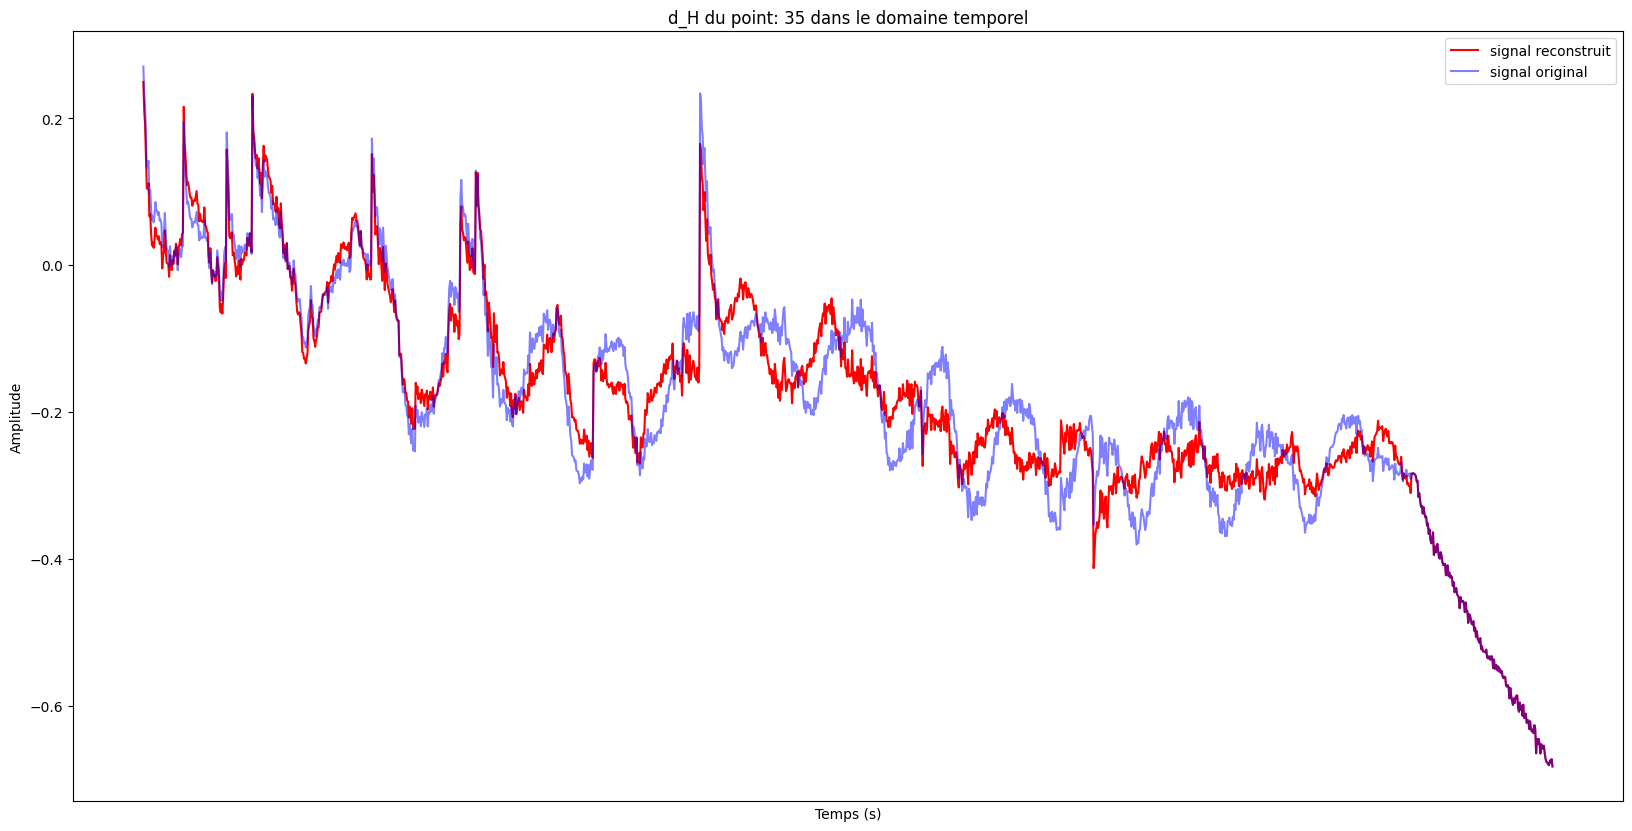

La longueur de la liste pression est: 1641 La longueur de la liste température est: 1641
Le Point 14 n'est pas corrélé
La longueur de la liste pression est: 536 La longueur de la liste température est: 536
Le Point 47 est corrélé
1289


/var/folders/95/14nx391x279gt37l3hnx_p_80000gn/T/ipykernel_90636/3375623881.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax[0].plot(data[K]['pression2']['temperature_stream'][:d], data[K]['pression2']['dH'][:d], color = 'blue', label = 'sans corrélation')
/var/folders/95/14nx391x279gt37l3hnx_p_80000gn/T/ipykernel_90636/3375623881.py:43: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax[1].plot(data[K]['pression2']['temperature_stream'][d:], data[K]['pression2']['dH'][d:], 

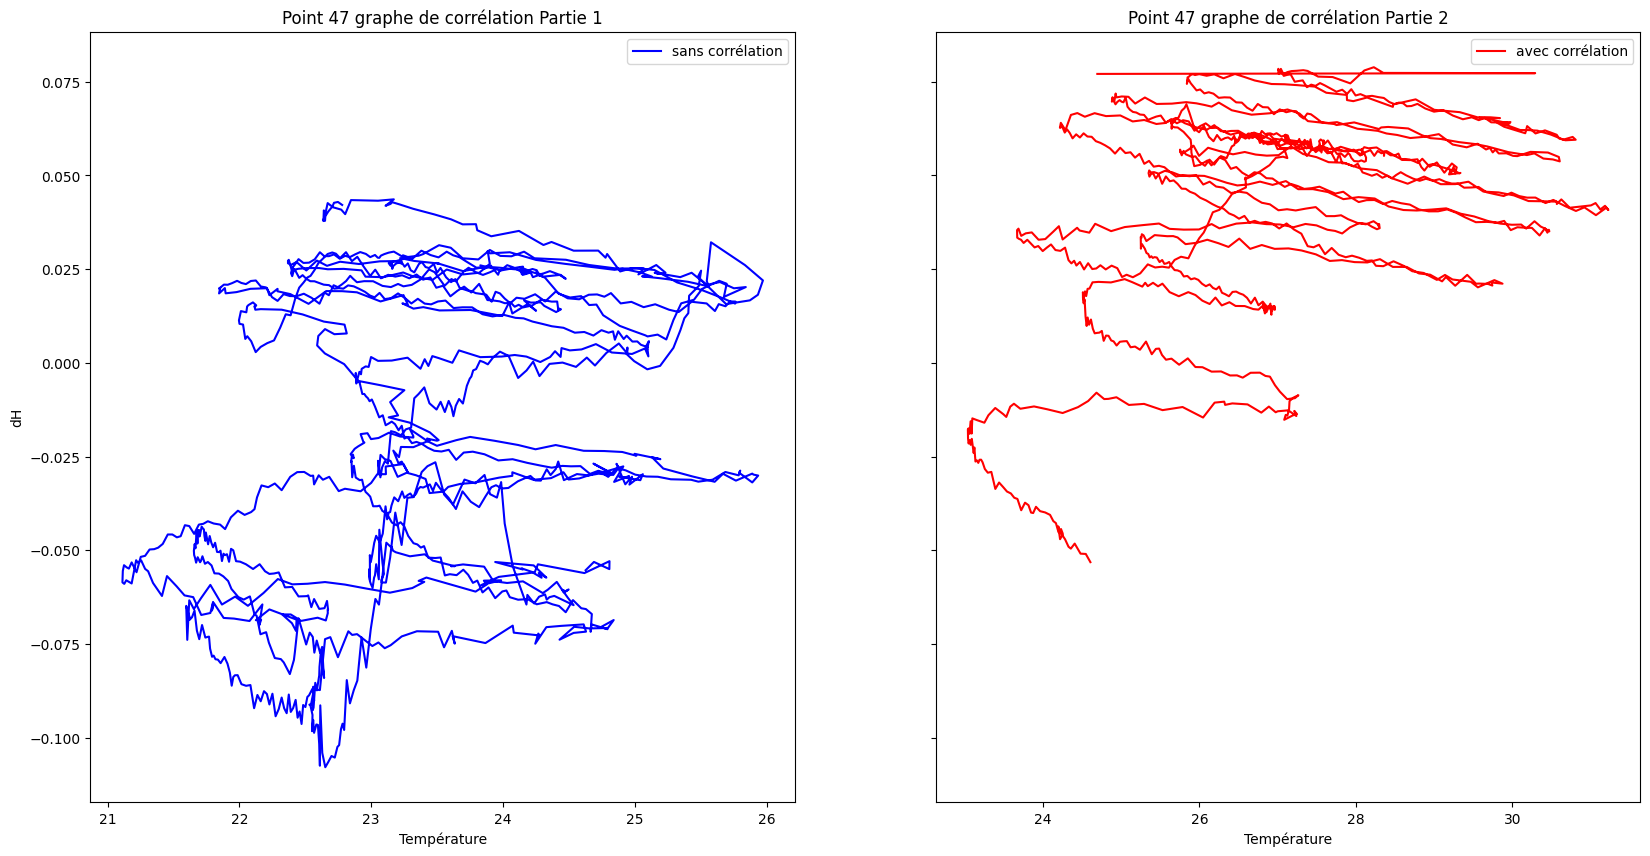

/var/folders/95/14nx391x279gt37l3hnx_p_80000gn/T/ipykernel_90636/3375623881.py:112: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax[0].plot(data[K]['pression2']['temperature_stream'][d:], data_sample_dH, color = 'blue', label = 'avant traitement')
/var/folders/95/14nx391x279gt37l3hnx_p_80000gn/T/ipykernel_90636/3375623881.py:113: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax[1].plot(data[K]['pression2']['temperature_stream'][d:], signal_reconstruit_dH, color = 'red', label = 

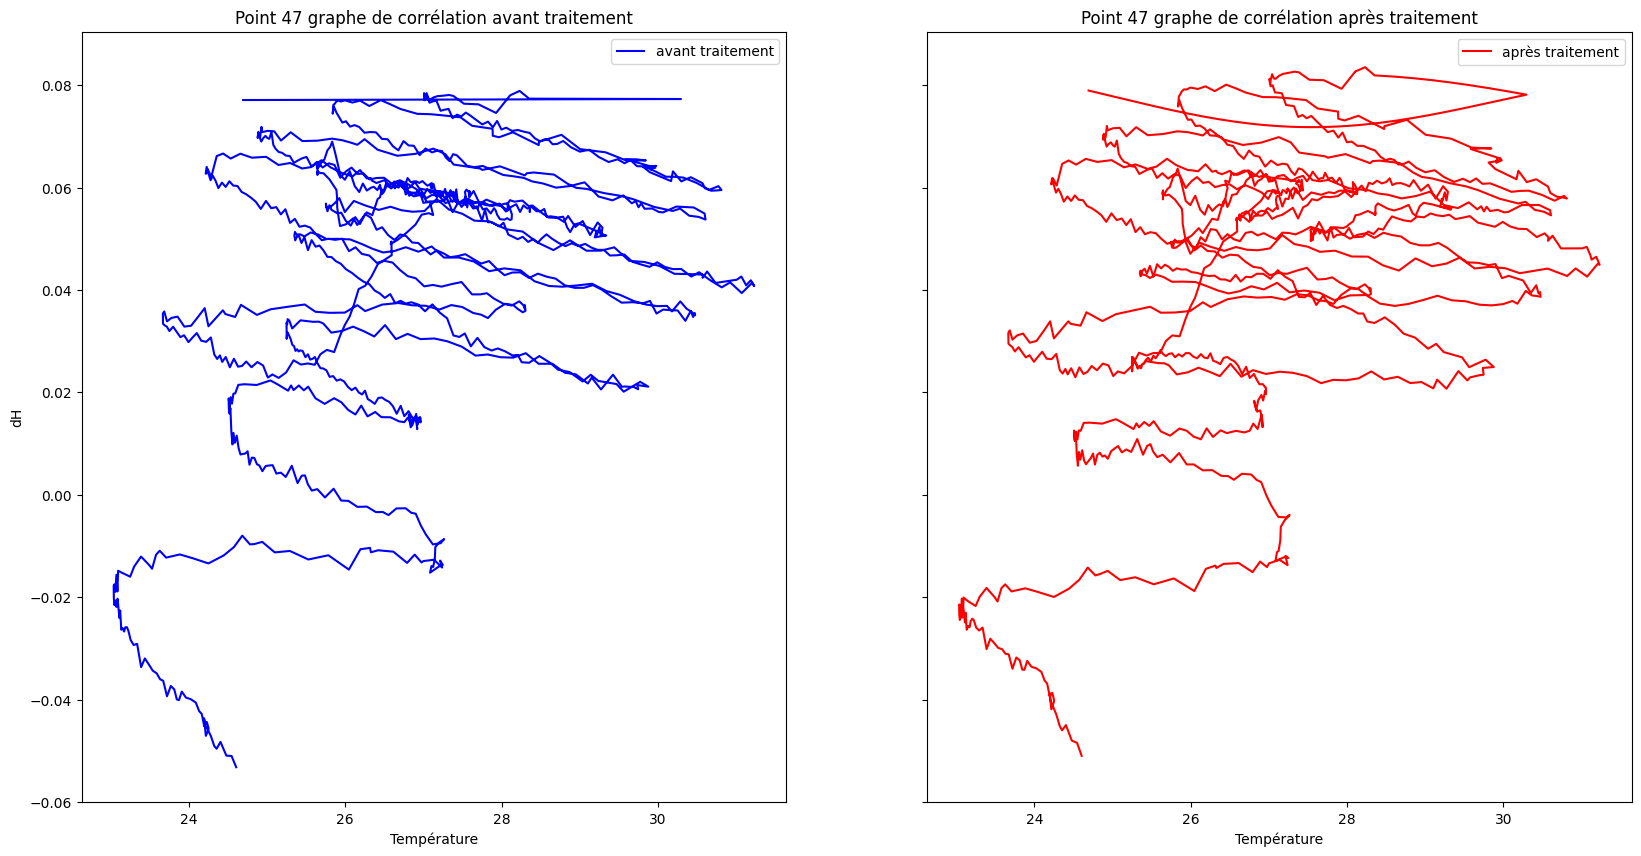

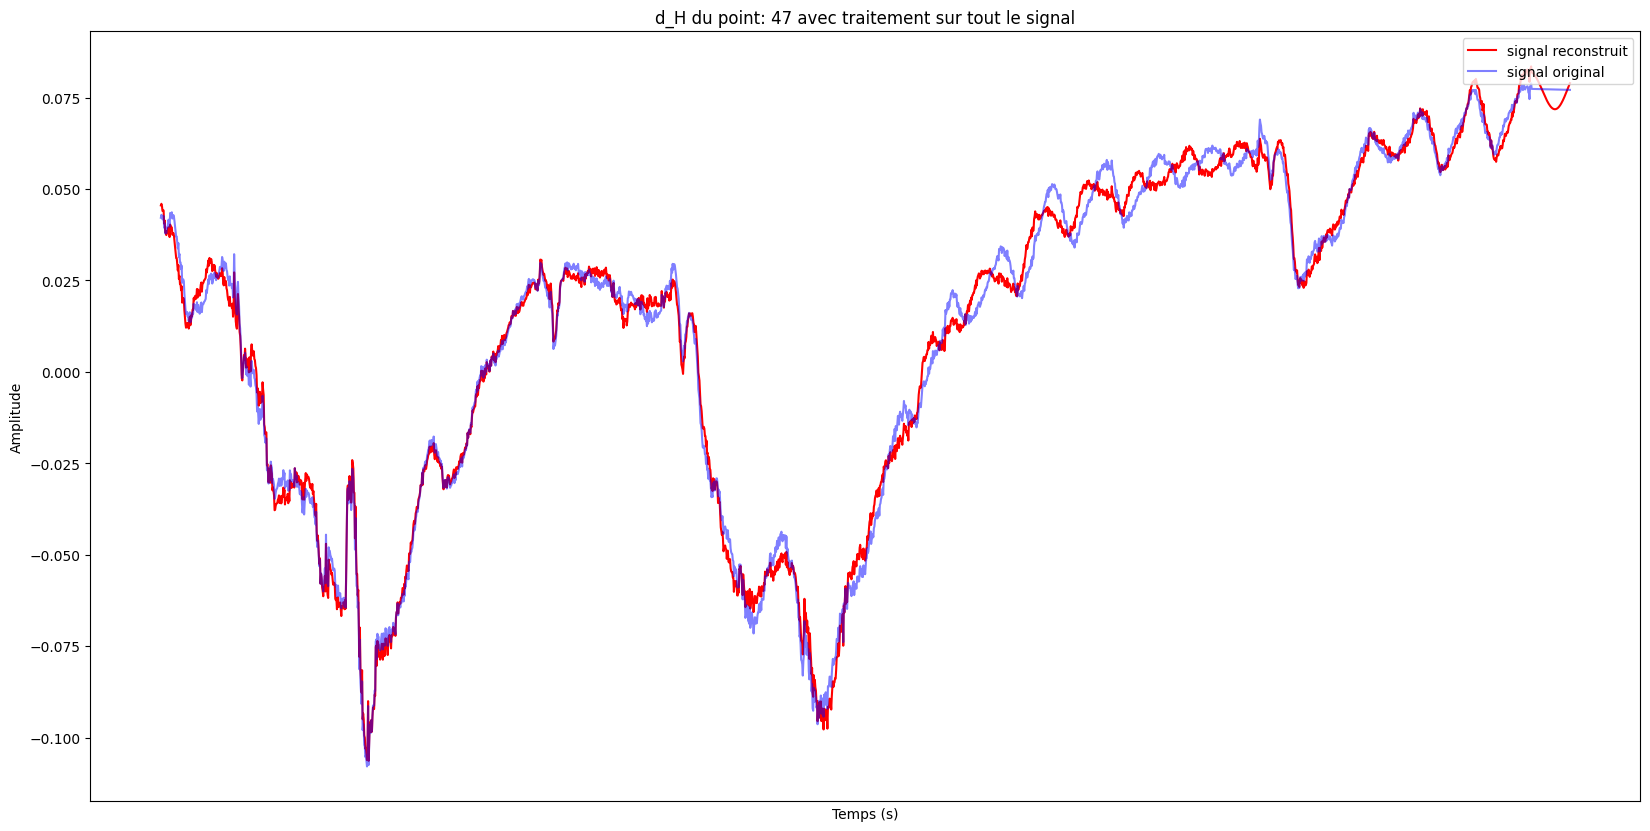

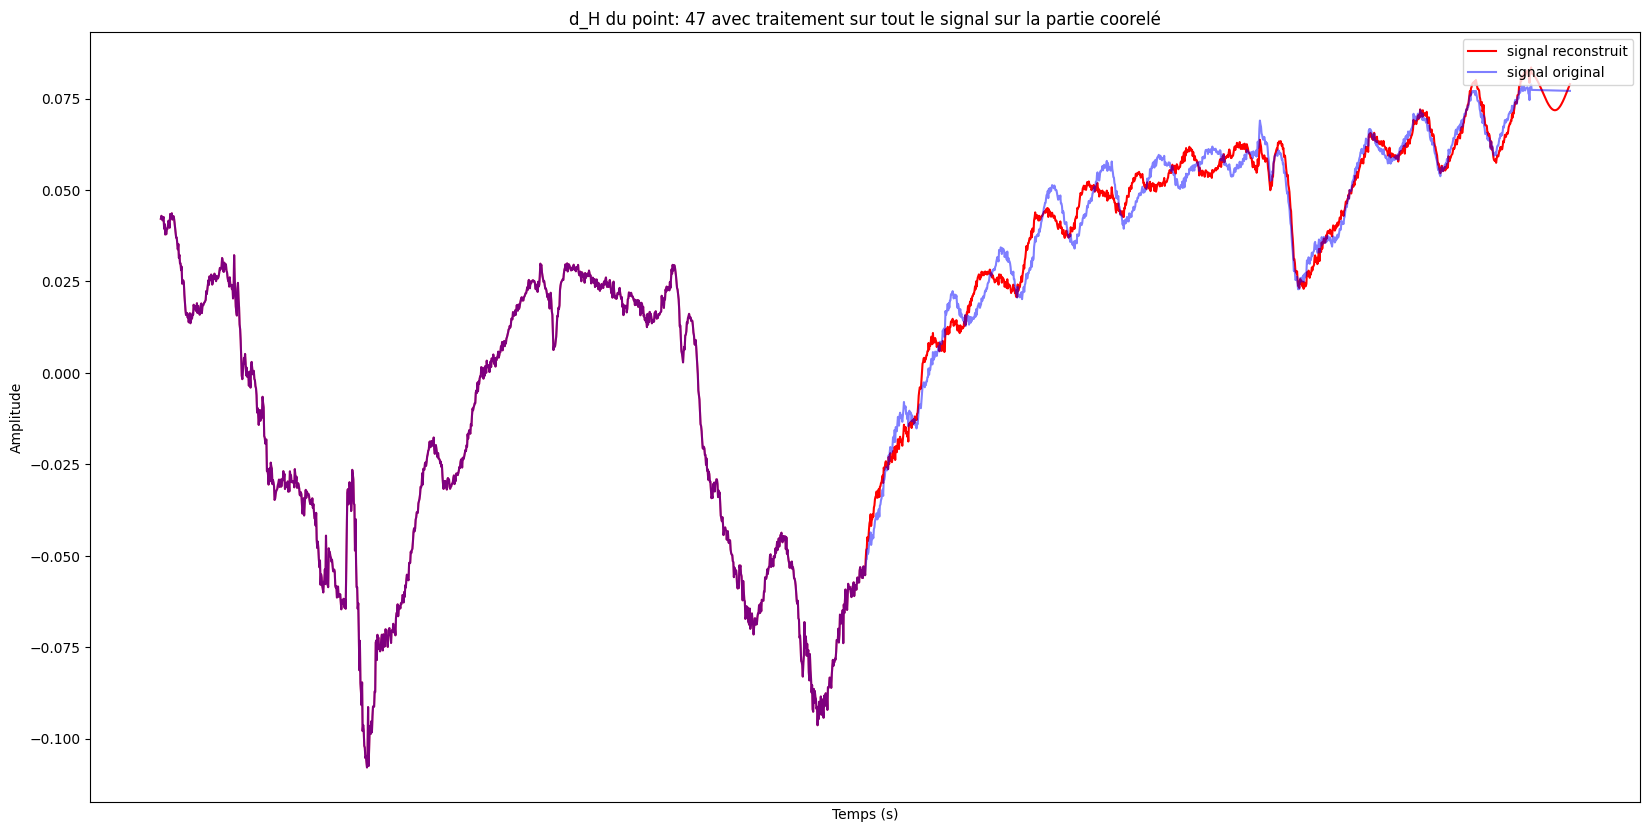

La longueur de la liste pression est: 2578 La longueur de la liste température est: 2578
Le Point 13 est corrélé


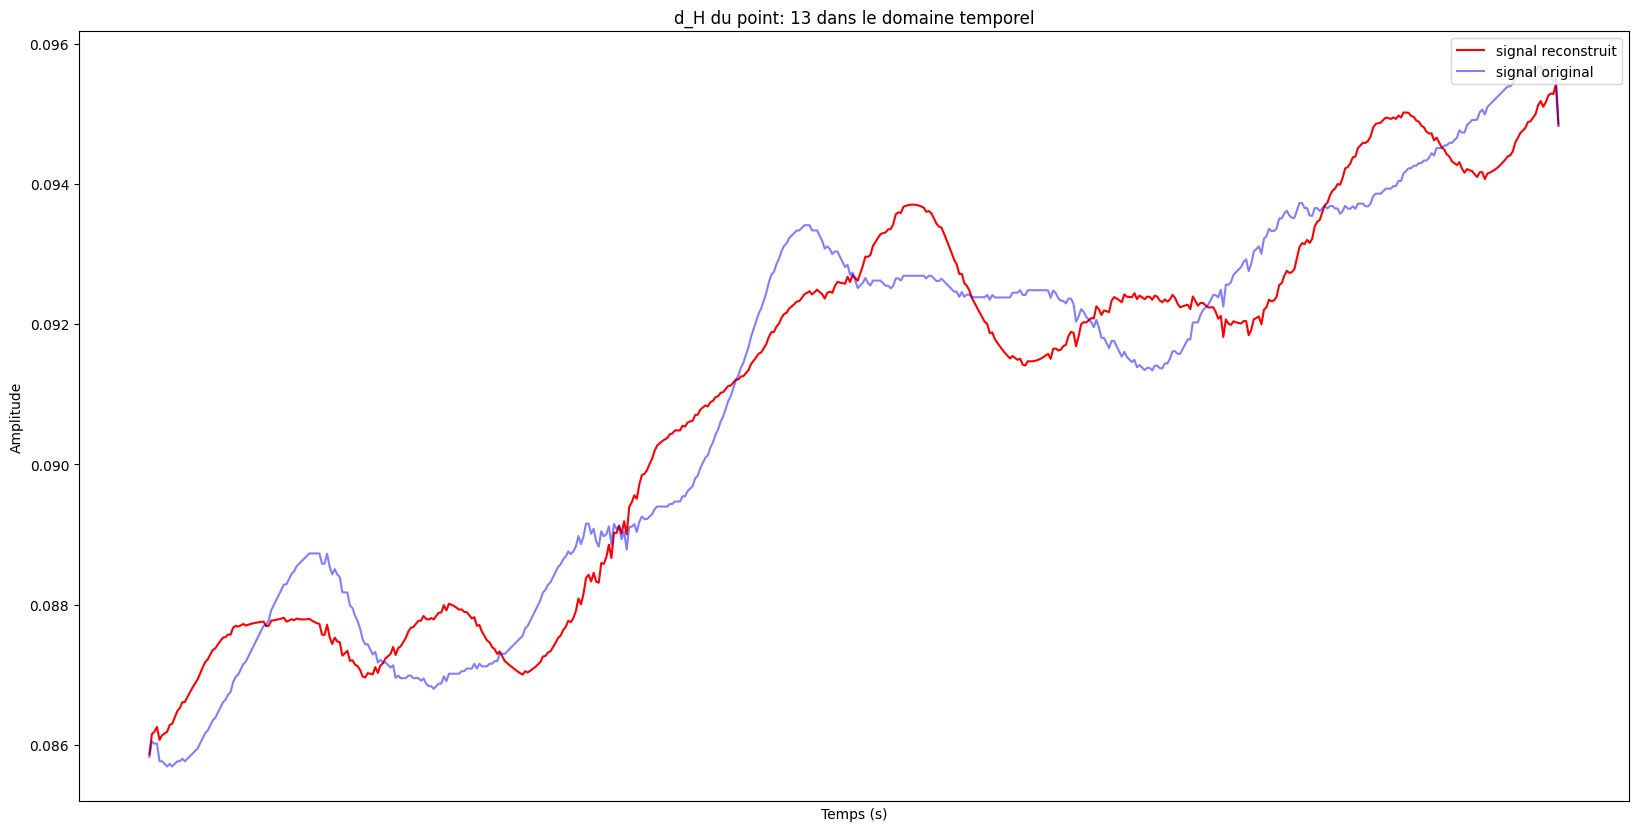

La longueur de la liste pression est: 556 La longueur de la liste température est: 556
Le Point 36 n'est pas corrélé
La longueur de la liste pression est: 1525 La longueur de la liste température est: 1525
Le Point 46 est corrélé
1327


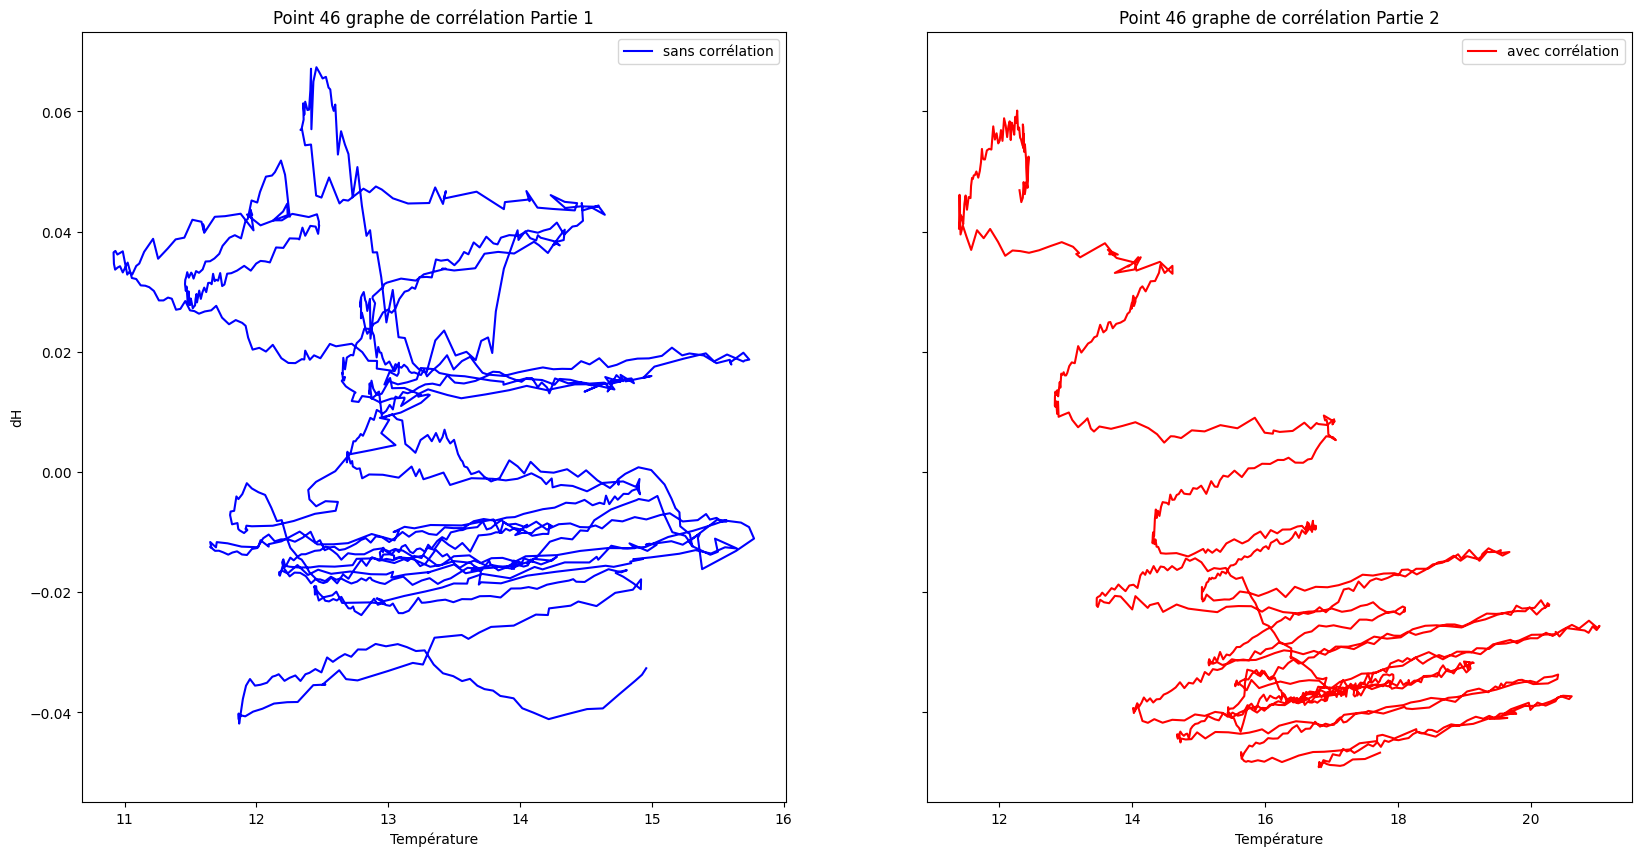

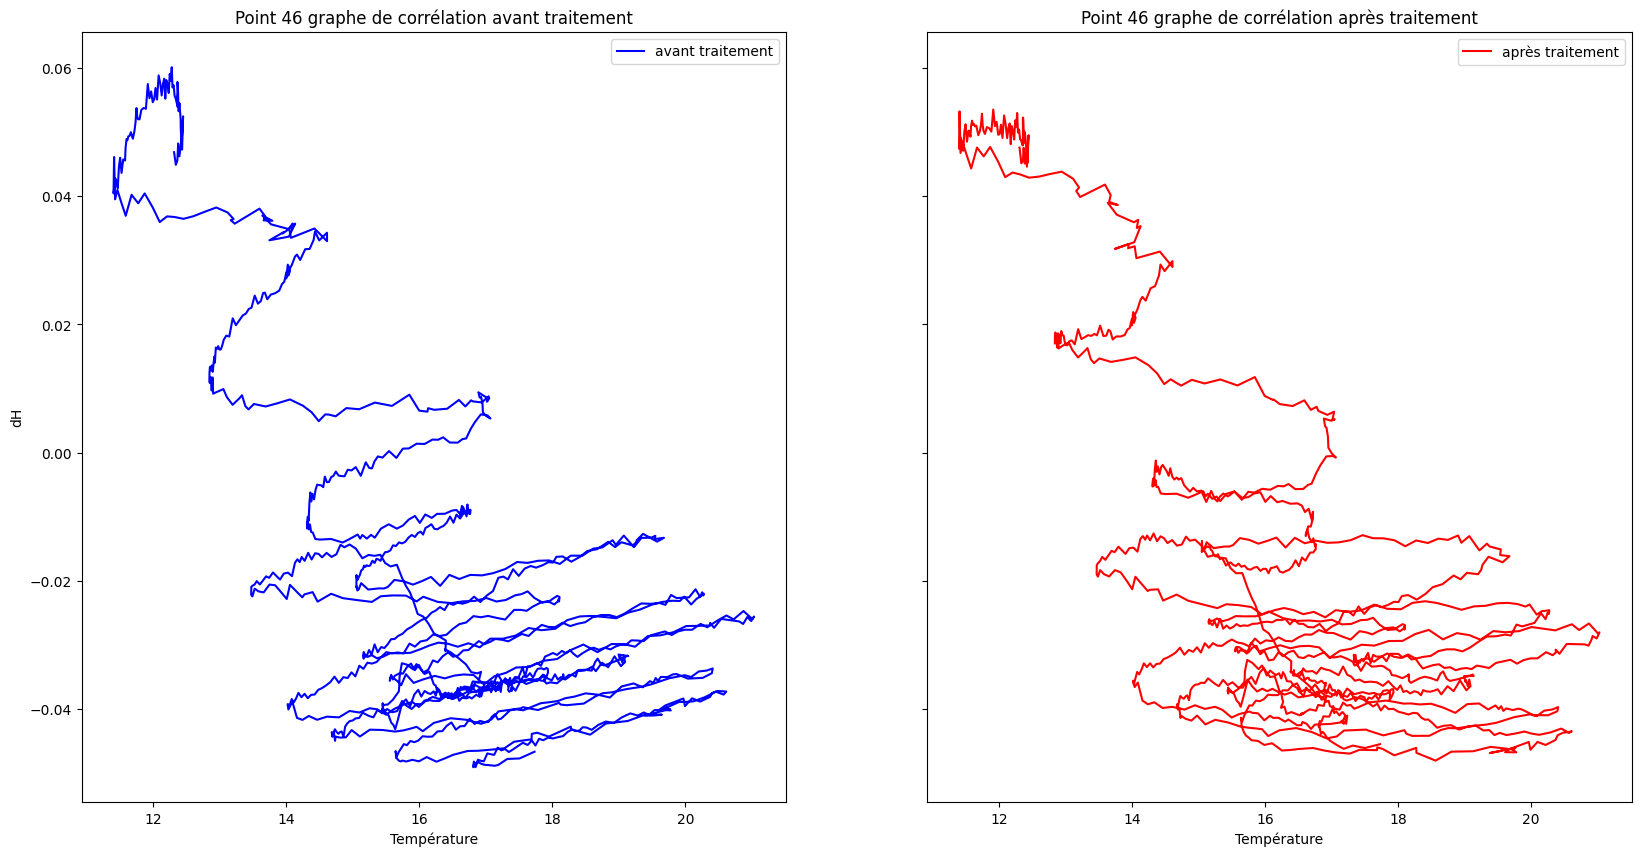

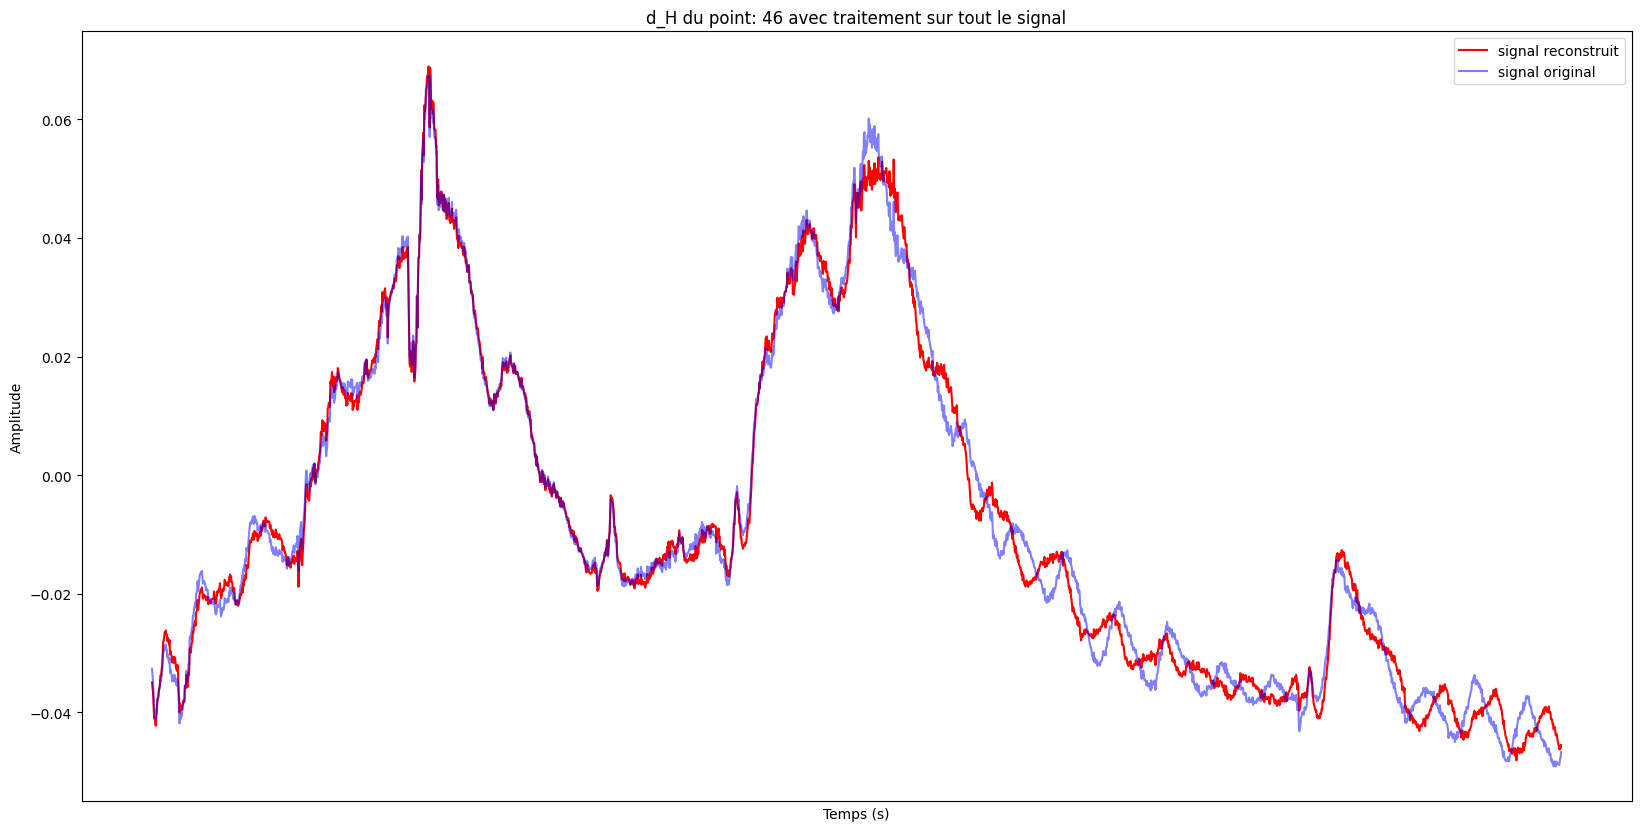

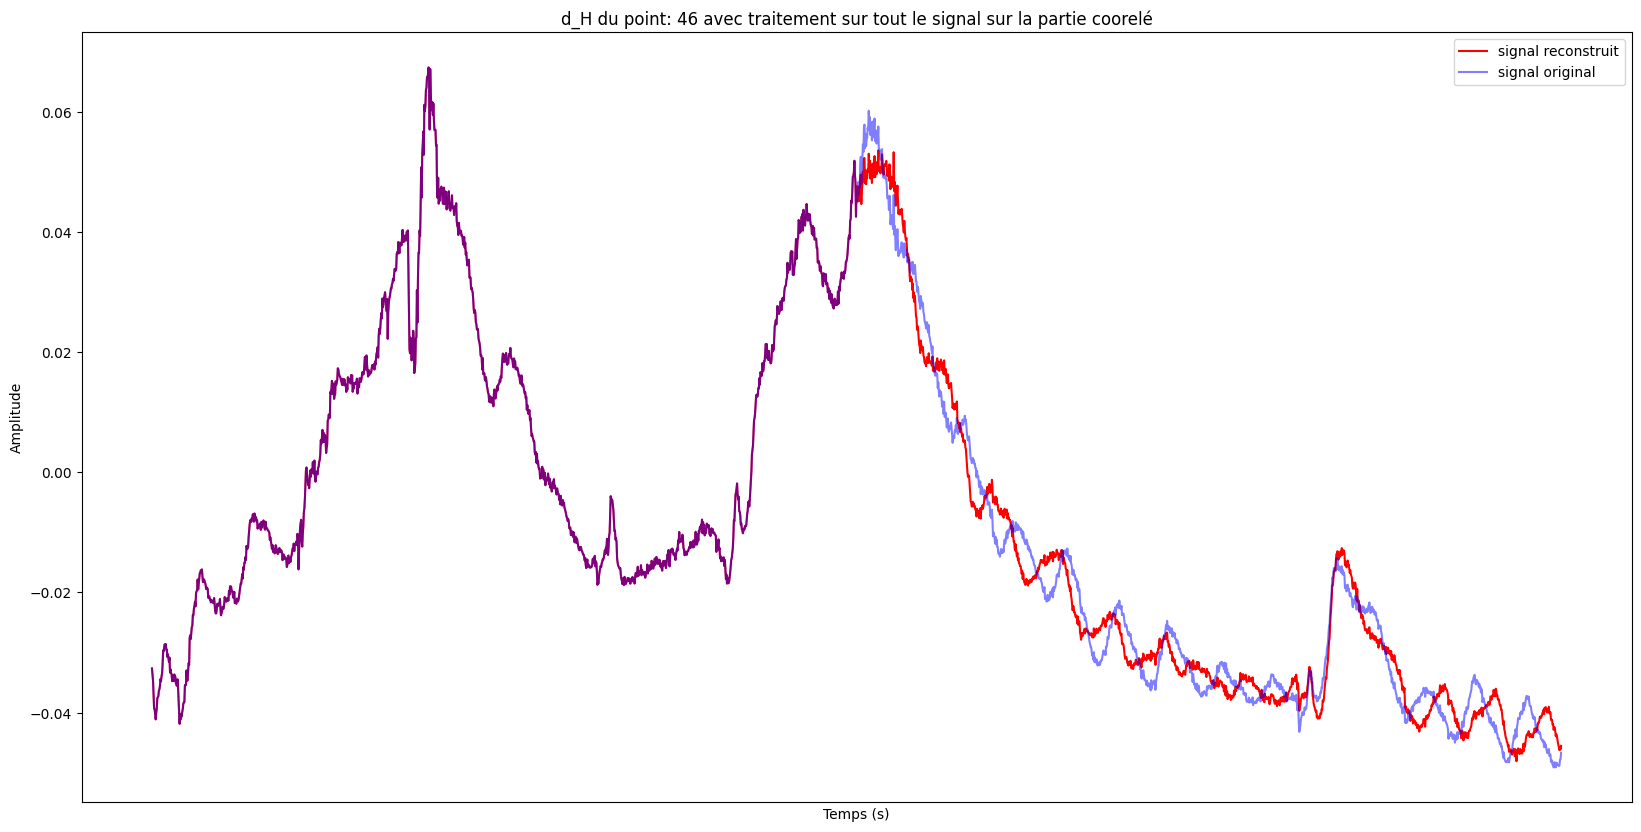

La longueur de la liste pression est: 2655 La longueur de la liste température est: 2655
Le Point 34 n'est pas corrélé
La longueur de la liste pression est: 1271 La longueur de la liste température est: 1271
Le Point 48 est corrélé


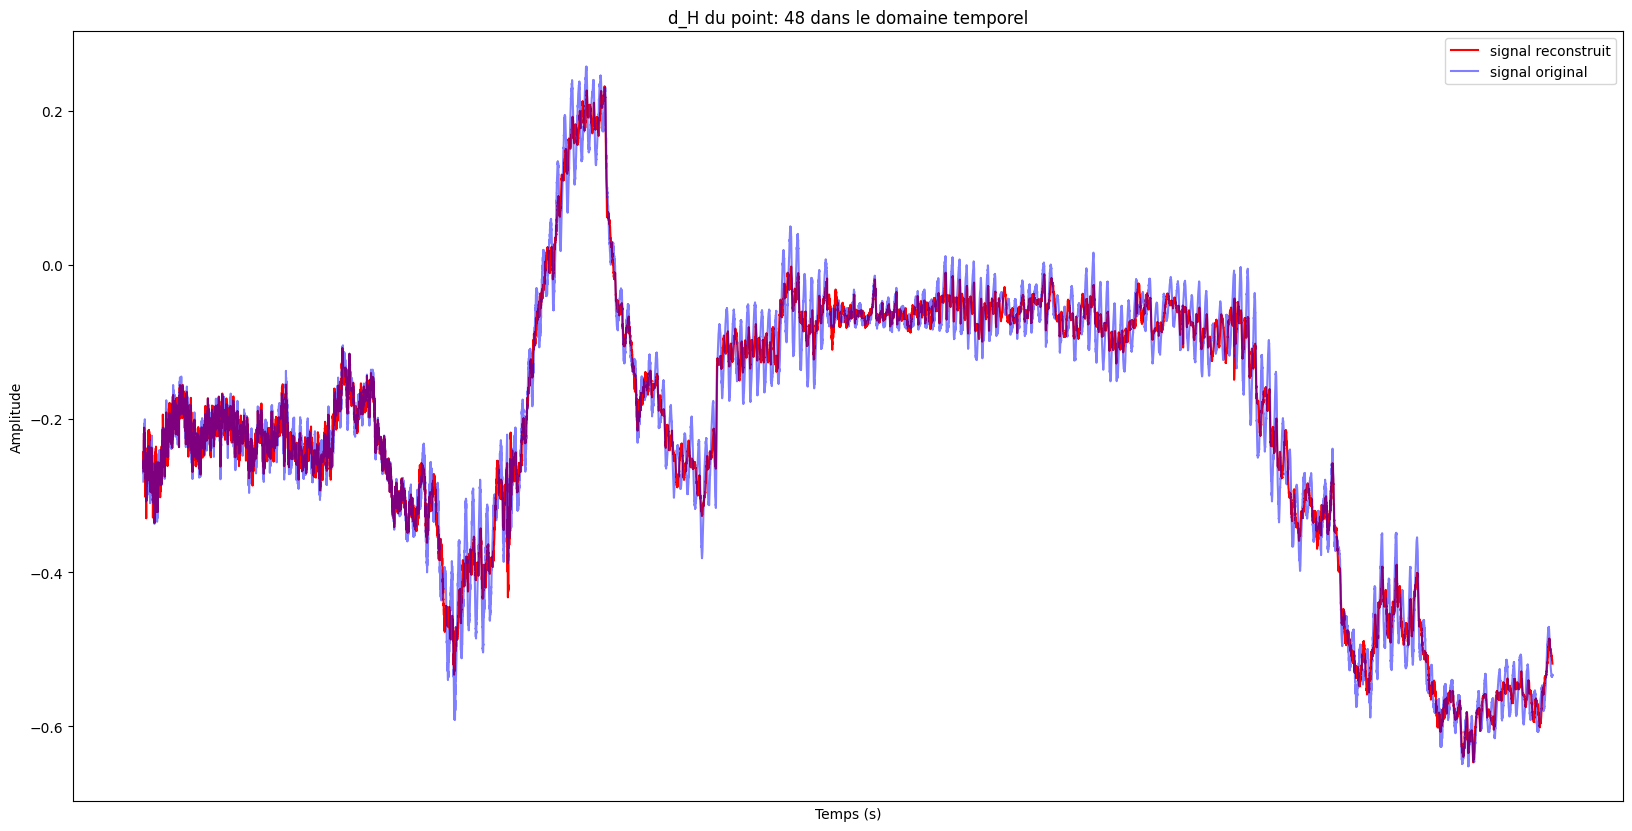

La longueur de la liste pression est: 19172 La longueur de la liste température est: 19172
Le Point 50 n'est pas corrélé
La longueur de la liste pression est: 1459 La longueur de la liste température est: 1459
Le Point 51 n'est pas corrélé
La longueur de la liste pression est: 2087 La longueur de la liste température est: 2087


In [252]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft

for j in numeroPoints:

    K = numeroPoints.index(j)

    if j in point_correler:

        print('Le Point ' + j + " est corrélé")

        #choix des points de pression
        
        data_sample_dH = np.array(data[K]['pression2']['dH'])
        data_abscisses=np.array(data[K]['pression2']['dates'])
        data_non_traite_dH = data_sample_dH.copy()

        #calcul de la fréquence d'échantillonnage

        sample_rate=1/(15/60) # 15 minutes

        data_non_correlé = [] 

        #Cas particulier de certaines points ou il ne faut que traiter un intervalle de temps

        if j == '35' :
            d = int(len(data_sample_dH)*(1-0.1))
            data_non_correlé = data_sample_dH[d:]
            data_sample_dH = data_sample_dH[:d]
        
        elif j == '47' or j == '46':
            
            d = int(len(data_sample_dH)*(1-0.5))
            data_non_correlé = data_sample_dH[:d]
            print(len(data_non_correlé))
            data_sample_dH = data_sample_dH[d:]
            
            #creer un subplot ayant deux colonnes une ligne

            fig , ax = plt.subplots(1, 2 ,figsize=(20,10), sharey=True)
            ax[0].plot(data[K]['pression2']['temperature_stream'][:d], data[K]['pression2']['dH'][:d], color = 'blue', label = 'sans corrélation')
            ax[1].plot(data[K]['pression2']['temperature_stream'][d:], data[K]['pression2']['dH'][d:], color = 'red', label = 'avec corrélation')
            ax[0].legend(loc='upper right')
            ax[1].legend(loc='upper right')
            ax[0].set_xlabel('Température')
            ax[1].set_xlabel('Température')
            ax[0].set_ylabel('dH')
            ax[0].set_title('Point ' + j + ' graphe de corrélation Partie 1')
            ax[1].set_title('Point ' + j + ' graphe de corrélation Partie 2')
            plt.show()

        # Calculer la transformée de Fourier du signal audio

        fft_result_dH = fft(data_sample_dH)
        frequencies_dH = fftfreq(len(fft_result_dH), d=1/sample_rate)

        #selection des fréquences entre ayant une periode d'environ 1 journée

        mask = np.where((frequencies_dH > 0.0385) & (frequencies_dH < 0.045), True, False)

        #on récupère les indices des fréquences sélectionnées

        interval_peaks_half = np.where(mask)[0]

        #ajouter des fréquences symétriques

        interval_peaks=list(interval_peaks_half)
        for l in interval_peaks_half:
            interval_peaks.append(len(mask)-l)

        #copie du signal fft_result_dH

        fft_result_dH_copy=fft_result_dH.copy()

        #on met à 0 les fréquences sélectionnées (les fréquences à éliminer)

        for l in interval_peaks:
            fft_result_dH_copy[l]=0

        # on reconstruit le signal 
            
        signal_reconstruit_dH = ifft(fft_result_dH_copy)

        if j == '35':

            signal_reconstruit_dH = list(signal_reconstruit_dH) + list(data_non_correlé)
            signal_reconstruit_dH = np.array(signal_reconstruit_dH)
            print(len(signal_reconstruit_dH),len(data_abscisses))
        
        if j == '47' or j == '46':

            fft_result_dH_non_correlé = fft(data_non_correlé)
            frequencies_dH_non_correlé = fftfreq(len(fft_result_dH_non_correlé), d=1/sample_rate)
            #selection des fréquences entre ayant une periode d'environ 1 journée
            mask_non_correlé = np.where((frequencies_dH_non_correlé > 0.0385) & (frequencies_dH_non_correlé < 0.045), True, False)
            #on récupère les indices des fréquences sélectionnées
            interval_peaks_half_non_correlé = np.where(mask_non_correlé)[0]
            #ajouter des fréquences symétriques
            interval_peaks_non_correlé=list(interval_peaks_half_non_correlé)
            for l in interval_peaks_half_non_correlé:
                interval_peaks_non_correlé.append(len(mask_non_correlé)-l)
            #copie du signal fft_result_dH
            fft_result_dH_non_correlé_copy=fft_result_dH_non_correlé.copy()
            #on met à 0 les fréquences sélectionnées (les fréquences à éliminer)
            for l in interval_peaks_non_correlé:
                fft_result_dH_non_correlé_copy[l]=0
            # on reconstruit le signal 
            signal_reconstruit_dH_non_correlé = ifft(fft_result_dH_non_correlé_copy)

            fig , ax = plt.subplots(1, 2 ,figsize=(20,10), sharey=True)
            ax[0].plot(data[K]['pression2']['temperature_stream'][d:], data_sample_dH, color = 'blue', label = 'avant traitement')
            ax[1].plot(data[K]['pression2']['temperature_stream'][d:], signal_reconstruit_dH, color = 'red', label = 'après traitement')
            ax[0].legend(loc='upper right')
            ax[1].legend(loc='upper right')
            ax[0].set_xlabel('Température')
            ax[1].set_xlabel('Température')
            ax[0].set_ylabel('dH')
            ax[0].set_title('Point ' + j + ' graphe de corrélation avant traitement')
            ax[1].set_title('Point ' + j + ' graphe de corrélation après traitement')
            signal_reconstruit_dH_list = list(signal_reconstruit_dH)
            signal_reconstruit_dH = list(data_non_correlé) + signal_reconstruit_dH_list
            signal_reconstruit_dH = np.array(signal_reconstruit_dH)
            signal_reconstruit_dH_2 = list(signal_reconstruit_dH_non_correlé) + signal_reconstruit_dH_list
            signal_reconstruit_dH_2 = np.array(signal_reconstruit_dH_2)

            # afficher signal reconstruit et signal original

            plt.figure(figsize=(20,10))
            # plt.plot(data_abscisses[L:], signal_reconstruit_dH[L:] , color='red', label='signal reconstruit')
            # plt.plot(data_abscisses[L:], data_non_traite_dH[L:], color='blue', label='signal original', alpha=0.5)
            plt.plot(data_abscisses, signal_reconstruit_dH_2, color='red', label='signal reconstruit')
            plt.plot(data_abscisses, data_non_traite_dH, color='blue', label='signal original', alpha=0.5)
            plt.xlabel("Temps (s)")
            # on retire les valeurs de l'axe des abscisses pour accélerer l'affichage
            plt.xticks([])
            plt.ylabel("Amplitude")
            plt.title("d_H du point: " + j + " avec traitement sur tout le signal")
            plt.legend(loc='upper right')
            plt.show()

            plt.figure(figsize=(20,10))
            plt.plot(data_abscisses, signal_reconstruit_dH, color='red', label='signal reconstruit')
            plt.plot(data_abscisses, data_non_traite_dH, color='blue', label='signal original', alpha=0.5)
            plt.xlabel("Temps (s)")
            # on retire les valeurs de l'axe des abscisses pour accélerer l'affichage
            plt.xticks([])
            plt.ylabel("Amplitude")
            plt.title("d_H du point: " + j + " avec traitement sur tout le signal sur la partie coorelé")
            plt.legend(loc='upper right')
            plt.show()

        else:
            # afficher signal reconstruit et signal original
            L=len(data_abscisses)//2
            plt.figure(figsize=(20,10))
            # plt.plot(data_abscisses[L:], signal_reconstruit_dH[L:] , color='red', label='signal reconstruit')
            # plt.plot(data_abscisses[L:], data_non_traite_dH[L:], color='blue', label='signal original', alpha=0.5)
            plt.plot(data_abscisses, signal_reconstruit_dH, color='red', label='signal reconstruit')
            plt.plot(data_abscisses, data_non_traite_dH, color='blue', label='signal original', alpha=0.5)
            plt.xlabel("Temps (s)")
            
            # on retire les valeurs de l'axe des abscisses pour accélerer l'affichage
            plt.xticks([])
            plt.ylabel("Amplitude")
            plt.title("d_H du point: " + j + " dans le domaine temporel")
            plt.legend(loc='upper right')
            plt.show()
            
        # remplacer les valeurs de dH par les valeurs du signal reconstruit (dH_filtre)

        data[K]['pression2']['dH'] = signal_reconstruit_dH.real

    else:
        print('Le Point ' + j + " n'est pas corrélé")

    #Verification de la longueur des données de température et de pression

    print("La longueur de la liste pression est:", len(data[K]['pression2']['dates']), "La longueur de la liste température est:", len(data[K]['temperature2']['dates']))

    #exporter les données de dh filtré dans un dossier csv nommé pointX_dH.csv
    
    export = pd.DataFrame(data[K]['pression2'])
    name_1 ='point'+ numeroPoints[K]+ '_pression_traité.csv'
    export.to_csv(name_1, index=False)  

    #déplacer le ficher csv dans le dossier data_traite

    os.replace(name_1, 'data_traite/' + name_1)

    #exporter les données de dh filtré dans un dossier csv nommé pointX_dH.csv

    export = pd.DataFrame(data[K]['temperature2'])
    name_2 ='point'+ numeroPoints[K]+ '_temperature_traité.csv'
    export.to_csv(name_2, index=False)  

    #déplacer le ficher csv dans le dossier data_traite

    os.replace(name_2, 'data_traite/' + name_2)


    